In [1]:
import numpy as np
import pandas as pd
import pickle

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from spike_train_utils import get_lv
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [3]:
save_fig=True

In [4]:
with open(dataset_folder + 'spike_trains_tau100ms_alpha0_3_fr3_5hz_len600sec_1000.pkl','rb') as f:
    data = pickle.load(f)

all_spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
tau_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(all_spike_trains)}, len {all_spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

lv_l = []
for spike_train in all_spike_trains:
    spike_train_int = np.asarray([int(spike) for spike in spike_train])
    lv = get_lv(spike_train_int, False)
    lv_l.append(lv)

n spike trains 1000, len 599.4657698736828, duration_ms 600000


In [5]:
with open(dataset_folder + 'spike_trains_3params_var_len600sec_100000.pkl','rb') as f:
    data_param = pickle.load(f)

all_spike_trains_param = data_param['spike_trains']
alphas_param = data_param['alphas']
fr_values_param = data_param['fr_values']
tau_ms_param = data_param['tau_ms']
duration_ms_param = data_param['duration_ms']

print(f'n spike trains {len(all_spike_trains_param)}, len {all_spike_trains_param[0][-1]/1000}, duration_ms {duration_ms_param}')

lv_param_l = []
for spike_train in all_spike_trains_param:
    spike_train_int = np.asarray([int(spike) for spike in spike_train])
    lv = get_lv(spike_train_int, False)
    lv_param_l.append(lv)

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [6]:
with open(dataset_folder + 'spike_trains_lv_1param_var_fr_len600sec_1000.pkl','rb') as f:
    data_fr_var = pickle.load(f)

all_spike_trains_fr_var = data_fr_var['spike_trains']
alphas_fr_var = data_fr_var['alphas']
fr_values_fr_var = data_fr_var['fr_values']
tau_ms_fr_var = data_fr_var['tau_ms']
duration_ms_fr_var = data_fr_var['duration_ms']

print(f'n spike trains {len(all_spike_trains_fr_var)}, len {all_spike_trains_fr_var[0][-1]/1000}, duration_ms {duration_ms_fr_var}')

lv_fr_var_l = []
for spike_train in all_spike_trains_fr_var:
    spike_train_int = np.asarray([int(spike) for spike in spike_train])
    lv = get_lv(spike_train_int, False)
    lv_fr_var_l.append(lv)

n spike trains 1000, len 599.9562391321374, duration_ms 600000


In [7]:
with open(dataset_folder + 'spike_trains_lv_1param_var_alpha_len600sec_1000.pkl','rb') as f:
    data_alpha_var = pickle.load(f)

all_spike_trains_alpha_var = data_alpha_var['spike_trains']
alphas_alpha_var = data_alpha_var['alphas']
fr_values_alpha_var = data_alpha_var['fr_values']
tau_ms_alpha_var = data_alpha_var['tau_ms']
duration_ms_alpha_var = data_alpha_var['duration_ms']

print(f'n spike trains {len(all_spike_trains_alpha_var)}, len {all_spike_trains_alpha_var[0][-1]/1000}, duration_ms {duration_ms_alpha_var}')

lv_alpha_var_l = []
for spike_train in all_spike_trains_alpha_var:
    spike_train_int = np.asarray([int(spike) for spike in spike_train])
    lv = get_lv(spike_train_int, False)
    lv_alpha_var_l.append(lv)

n spike trains 1000, len 596.9505833493956, duration_ms 600000


### Save params Lv df

In [10]:
lv_df = pd.DataFrame({
    'alpha':   alphas_param,
    'fr':      fr_values_param,
    'tau_ms':  tau_ms_param,
    'lv':      lv_param_l
})

lv_df.insert(0,'unit_id',lv_df.index)
lv_df.head(3)

,unit_id,alpha,fr,tau_ms,lv
0,0,0.851099,7.741821,150.923515,1.307775
1,1,0.858098,4.394396,147.947233,1.345006
2,2,0.528805,8.587393,267.002290,1.068416


In [12]:
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

lv_df.to_pickle(results_folder + 'lv_df.pkl')
lv_df.to_csv(results_folder + 'lv_df.csv')

### Plots

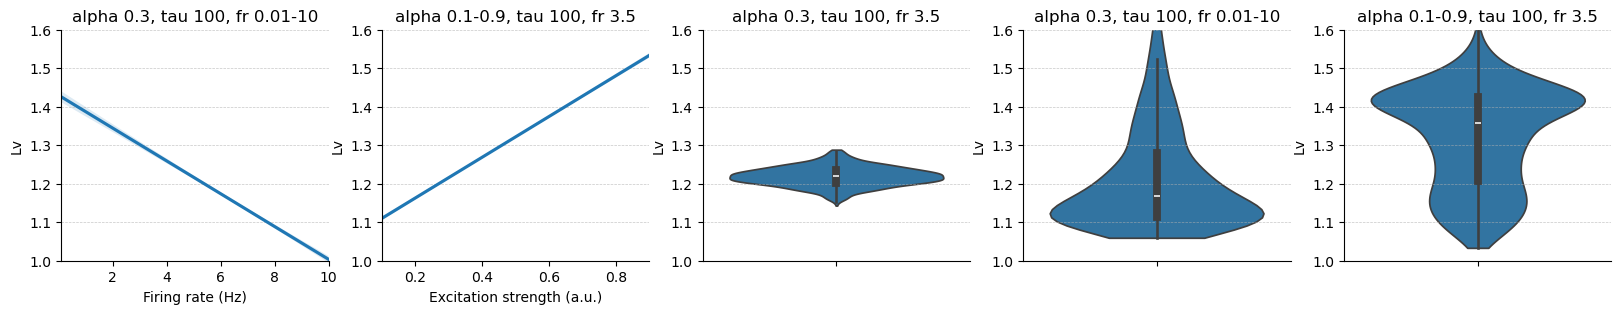

In [13]:
fig, axes = plt.subplots(1,5, figsize=(20, 3), sharey=False)

sns.regplot(x=fr_values_fr_var, y=lv_fr_var_l, scatter=None, ax=axes[0])
axes[0].set_xlabel('Firing rate (Hz)')
axes[0].set_xlim([0.1, 10])
axes[0].set_title('alpha 0.3, tau 100, fr 0.01-10') 

sns.regplot(x=alphas_alpha_var, y=lv_alpha_var_l, scatter=None, ax=axes[1])
axes[1].set_xlabel('Excitation strength (a.u.)')
axes[1].set_xlim([0.1, 0.9])
axes[1].set_title('alpha 0.1-0.9, tau 100, fr 3.5') 

sns.violinplot(y=lv_l, cut=0, density_norm='width', ax=axes[2])
axes[2].set_title('alpha 0.3, tau 100, fr 3.5') 

sns.violinplot(y=lv_fr_var_l, cut=0, density_norm='width', ax=axes[3])
axes[3].set_title('alpha 0.3, tau 100, fr 0.01-10') 

sns.violinplot(y=lv_alpha_var_l, cut=0, density_norm='width', ax=axes[4])
axes[4].set_title('alpha 0.1-0.9, tau 100, fr 3.5') 


for ax in axes.flat:
    ax.set_ylabel('Lv')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_ylim([1,1.6])

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'lv_checks.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_checks.svg' , bbox_inches='tight')

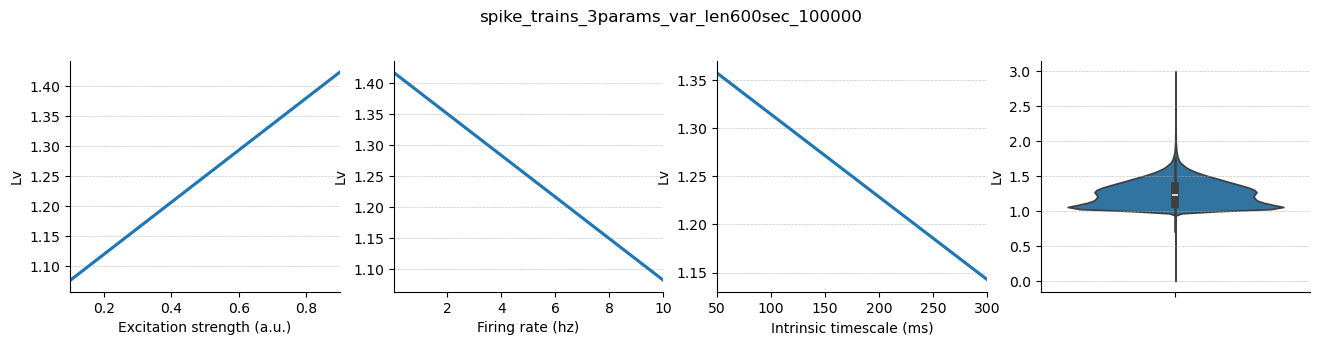

In [14]:
fig, axes = plt.subplots(1,4, figsize=(16, 3), sharey=False)

sns.regplot(x=alphas_param, y=lv_param_l, scatter=None, ax=axes[0])
axes[0].set_xlim([0.1, 0.9])
axes[0].set_xlabel('Excitation strength (a.u.)')

sns.regplot(x=fr_values_param, y=lv_param_l, scatter=None, ax=axes[1])
axes[1].set_xlim([0.01, 10])
axes[1].set_xlabel('Firing rate (hz)')

sns.regplot(x=tau_ms_param, y=lv_param_l, scatter=None, ax=axes[2])
axes[2].set_xlim([50, 300])
axes[2].set_xlabel('Intrinsic timescale (ms)')

sns.violinplot(y=lv_param_l, cut=0, density_norm='width', ax=axes[3])

for ax in axes.flat:
    ax.set_ylabel('Lv')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

sns.despine()

fig.suptitle('spike_trains_3params_var_len600sec_100000', y=1.05)

if save_fig:
    plt.savefig(fig_folder + 'lv_checks_param_dataset.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_checks_param_dataset.svg' , bbox_inches='tight')

1.01665143355302 1.6652347001780416


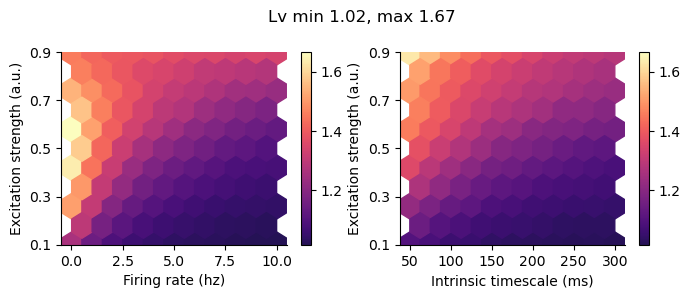

In [15]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a new colormap based on cmap but only sampling its colors
    between minval and maxval (both in [0,1]).
    """
    new_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap.name}_trunc_{minval:.2f}_{maxval:.2f}",
        new_colors
    )
    return new_cmap


fig, axes = plt.subplots(1,2, figsize=(8,2.5))

#norm = TwoSlopeNorm(vcenter=0)

trunc_magma = truncate_colormap(plt.cm.magma, minval=0.15, maxval=1)

hb0 = axes[0].hexbin(
    x=fr_values_param, y=alphas_param,
    C=lv_param_l,
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap=trunc_magma,
    #norm = norm,
    mincnt=1                    
)

hb1 = axes[1].hexbin(
    x=tau_ms_param, y=alphas_param,
    C=lv_param_l,
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap=trunc_magma,
    #norm = norm,
    mincnt=1                    
)


vmin = np.min([hb0.get_array().min(), hb1.get_array().min()])
vmax = np.max([hb0.get_array().max(), hb1.get_array().max()])
print(vmin, vmax)

hb0.set_clim(vmin, vmax)
hb1.set_clim(vmin, vmax)

fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_xticks(np.linspace(50, 300, 6))

fig.suptitle(f'Lv min {vmin:.2f}, max {vmax:.2f}', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

if save_fig:
    plt.savefig(fig_folder + 'lv_vs_3params_param_dataset.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_vs_3params_param_dataset.svg' , bbox_inches='tight')